In [1]:
!pip install -q twelvedata pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 2.5 MB/s eta 0:00:00


['EURUSD', 'USDJPY', 'GC=F', 'DX-Y.NYB', 'CL=F'] [-95, 89, -80, 92, -82]
DatetimeIndex(['2025-01-09 16:00:00+00:00', '2025-01-09 17:00:00+00:00',
               '2025-01-09 18:00:00+00:00', '2025-01-09 19:00:00+00:00',
               '2025-01-09 20:00:00+00:00', '2025-01-09 21:00:00+00:00',
               '2025-01-09 22:00:00+00:00', '2025-01-09 23:00:00+00:00',
               '2025-01-10 00:00:00+00:00', '2025-01-10 01:00:00+00:00',
               '2025-01-10 02:00:00+00:00', '2025-01-10 03:00:00+00:00',
               '2025-01-10 04:00:00+00:00', '2025-01-10 05:00:00+00:00',
               '2025-01-10 06:00:00+00:00', '2025-01-10 07:00:00+00:00',
               '2025-01-10 08:00:00+00:00', '2025-01-10 09:00:00+00:00',
               '2025-01-10 10:00:00+00:00', '2025-01-10 11:00:00+00:00',
               '2025-01-10 12:00:00+00:00', '2025-01-10 13:00:00+00:00',
               '2025-01-10 14:00:00+00:00', '2025-01-10 15:00:00+00:00',
               '2025-01-10 16:00:00+00:00', '2025-0

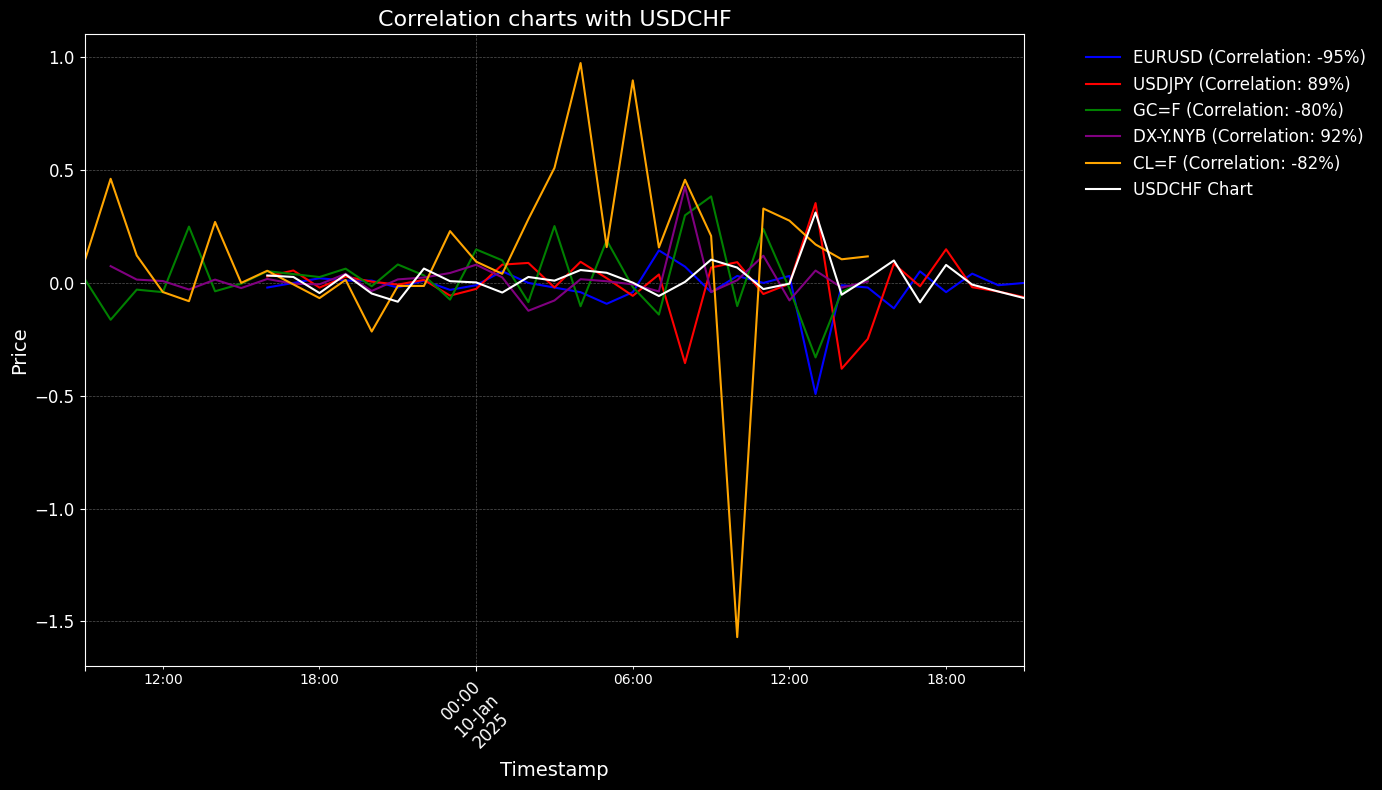

In [36]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import matplotlib.dates as mdates
import copy
from datetime import datetime, timedelta

class CorrelationChartingTool:
    def __init__(self, ticker):
        self.ticker = ticker.upper()
        correlations = self.get_correlation_tickers(self.ticker)
        self.correlation_tickers, self.correlation_percentages = [ticker for ticker,percentage in correlations], [percentage for ticker,percentage in correlations]
        print(self.correlation_tickers, self.correlation_percentages)
        correlated_dataframes_price = [self.get_data(ticker) for ticker in self.correlation_tickers]
        self.correlated_dataframes = [self.convert_price_to_percentage(df) for df in correlated_dataframes_price]
        ticker_df = self.get_data(ticker)
        self.ticker_df = self.convert_price_to_percentage(ticker_df)
        self.plot_correlation_chart(self.ticker_df, self.correlated_dataframes)


    def get_data(self, ticker="eurusd", period=3, interval="1h", provider='yfinance'): #optimized
          forex_pairs = ["EURUSD", "USDJPY", "GBPUSD", "USDCHF", "AUDUSD", "USDCAD", "NZDUSD","EURGBP", "EURJPY", "GBPJPY", "AUDJPY", "NZDJPY", "AUDNZD", "EURAUD","GBPAUD", "EURCAD", "GBPCAD", "EURNZD", "GBPNZD", "CHFJPY", "CADJPY","AUDCAD", "NZDCAD", "AUDCHF", "NZDCHF", "CADCHF","USDSEK", "USDNOK", "USDDKK", "USDZAR", "USDTRY", "USDMXN", "USDSGD","USDHKD", "USDKRW", "USDTHB", "USDCNH", "USDPLN", "USDHUF", "USDCZK","EURSEK", "EURNOK", "EURDKK", "EURTRY", "EURZAR", "EURSGD", "EURHUF","EURPLN", "EURCZK", "GBPSEK", "GBPNOK", "GBPDKK", "GBPTRY", "GBPZAR","AUDSGD", "AUDHKD", "AUDPLN", "CADSGD", "NZDSGD", "SGDJPY", "NOKJPY","SEKJPY", "ZARJPY", "TRYJPY", "MXNJPY"]
          ticker_type = 'stock'
          if ticker.upper() in forex_pairs:
            ticker_type='forex'
          if provider.lower() == 'yfinance':
              import yfinance as yf
              if ticker_type.lower() == 'forex':
                ticker = yf.Ticker(f"{ticker.upper()}=X")
              else:
                ticker = yf.Ticker(ticker.upper())
              #df = ticker.history(period="max", interval=interval)
              df = ticker.history(period="1y", interval=interval)
              df.rename(columns={'Close': 'close', 'Open': 'open', 'Low':'low', 'High': 'high'}, inplace=True)
              #df.drop(columns=['Volume', 'Dividends', 'Stock Splits'],axis='columns', inplace=True)
              df = df.iloc[:-1] #dropping last row cuz yfinance shows a candle even tho its not finished

          return df

    def convert_price_to_percentage(self,df):  #optimized
        converted_df = df.pct_change() * 100
        converted_df = converted_df.fillna(0)
        return converted_df

    def get_correlation_tickers(self, ticker):
        ticker = ticker[:3].upper()  # Normalize the input ticker
        correlations = {
        'USD': [('EURUSD', -95), ('USDJPY', 89), ('GC=F', -80), ('DX-Y.NYB', 92), ('CL=F', -82)],
        'EUR': [('EURUSD', 95), ('EURGBP', 88), ('EURAUD', 80), ('GC=F', -78), ('EURJPY', 87)],
        'GBP': [('EURGBP', 88), ('GBPUSD', 87), ('GBPJPY', 84), ('CL=F', 83), ('^FTSE', 82)],
        'AUD': [('EURAUD', 80), ('AUDUSD', 83), ('AUDJPY', 79), ('GC=F', 77), ('^AXJO', 81)],
        'CAD': [('USDCAD', 90), ('CADJPY', 85), ('CADCHF', 82), ('CL=F', 88), ('^GSPC', 80)],
        'CHF': [('USDCHF', 85), ('CHFJPY', 78), ('EURCHF', 81), ('GC=F', -79), ('SMI', 80)],
        'JPY': [('USDJPY', 89), ('EURJPY', 87), ('GBPJPY', 86), ('^N225', 84), ('GC=F', -80)],
        'NZD': [('NZDUSD', 84), ('AUDNZD', 83), ('NZDJPY', 82), ('DairyPrices', 85), ('GC=F', 80)]}
        if ticker in correlations:
            return correlations[ticker]
        else:
            return f"No correlation data available for ticker: {ticker}"


    def plot_correlation_chart(self, ticker_df, correlation_dfs=list):
        color_list = ['blue', 'red', 'green', 'purple', 'orange', 'pink','blue', 'red', 'green', 'purple', 'orange', 'pink','blue', 'red', 'green', 'purple', 'orange', 'pink','blue', 'red', 'green', 'purple', 'orange', 'pink','blue', 'red', 'green', 'purple', 'orange', 'pink']
        num_rows = len(correlation_dfs[0])
        quarter_index = int(num_rows * 0.995)
        plt.style.use('dark_background')
        fig, ax = plt.subplots(figsize=(14, 8))
        zoom = -30
        for i, df in enumerate(correlation_dfs):
            try:
                if len(df)==0:
                    continue
                df = df.iloc[zoom:]
                df.index = pd.to_datetime(df.index)
                df['close'].plot(ax=ax, linestyle='-', color=color_list[i], label=f'{self.correlation_tickers[i]} (Correlation: {self.correlation_percentages[i]}%)')
            except Exception as e:
                print(e)
        ticker_df = ticker_df.iloc[zoom:]
        ticker_df.index = pd.to_datetime(ticker_df.index)
        print(ticker_df.index)
        ticker_df['close'].plot(ax=ax, linestyle='-', color='white', label=f'{self.ticker} Chart')


        ax.set_title(f"Correlation charts with {self.ticker}", fontsize=16, color='white')
        ax.set_xlabel('Timestamp', fontsize=14, color='white')
        ax.set_ylabel('Price', fontsize=14, color='white')
        ax.tick_params(axis='both', which='major', labelsize=12, colors='white')
        #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.xticks(rotation=45)
        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12, frameon=False)
        ax.grid(True, color='#555555', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()
tool = CorrelationChartingTool(ticker='usdchf')
